In [567]:
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

## Сырые данные по РФ


In [568]:
# Пример данных
df = pd.read_csv('regional_data/raw_Российская_Федерация.csv')
df['Date'] = pd.to_datetime(df['Date'])
y = df["inflation"] / 100
df.drop(['inflation', 'Date'], axis=1, inplace=True)
df.head()

,trade_turnover,debt_firms,money_income,paid_services,unemp,fm_changes_volume,fm_changes_costs,fm_changes_demand,fm_volume_exp,fm_demand_exp,...,fm_consumer_risk,fm_price_final_prod,fm_ibk,fm_econom_position,fm_econom_cond,Brent,MIACR,Infl_exp,M2,obligates
0,1840650960.80,18171671.00,29535.00,559456677.90,1.20,-33.64,16.55,-19.00,19.52,17.86,...,-26.88,8.88,-5.19,-3.66,-13.87,108.12,6.06,13.04,31155.60,6.20
1,1853102881.76,18184819.00,29233.00,571950883.80,1.20,0.24,19.85,-5.42,22.33,20.61,...,-12.19,9.03,9.08,-3.03,-7.68,108.90,5.99,11.80,29861.20,6.39
2,2032552773.82,18458002.00,31403.00,591568267.20,1.30,10.32,21.99,0.58,21.65,20.25,...,-6.89,9.30,13.03,-2.56,-4.20,107.48,7.85,11.52,30169.00,7.40
3,2023565042.70,18790056.00,32949.00,599205733.80,1.20,3.79,19.21,0.61,21.71,19.75,...,-7.26,8.45,11.26,-1.83,-3.64,107.76,7.87,12.67,29519.30,7.50
4,2075030365.12,19052987.00,32270.00,585407816.10,1.00,-0.03,17.33,-1.84,20.18,17.87,...,-9.34,6.20,8.81,-0.94,-3.26,109.54,8.21,11.72,29879.00,7.95


## Как выглядит распределение рядов без обработки


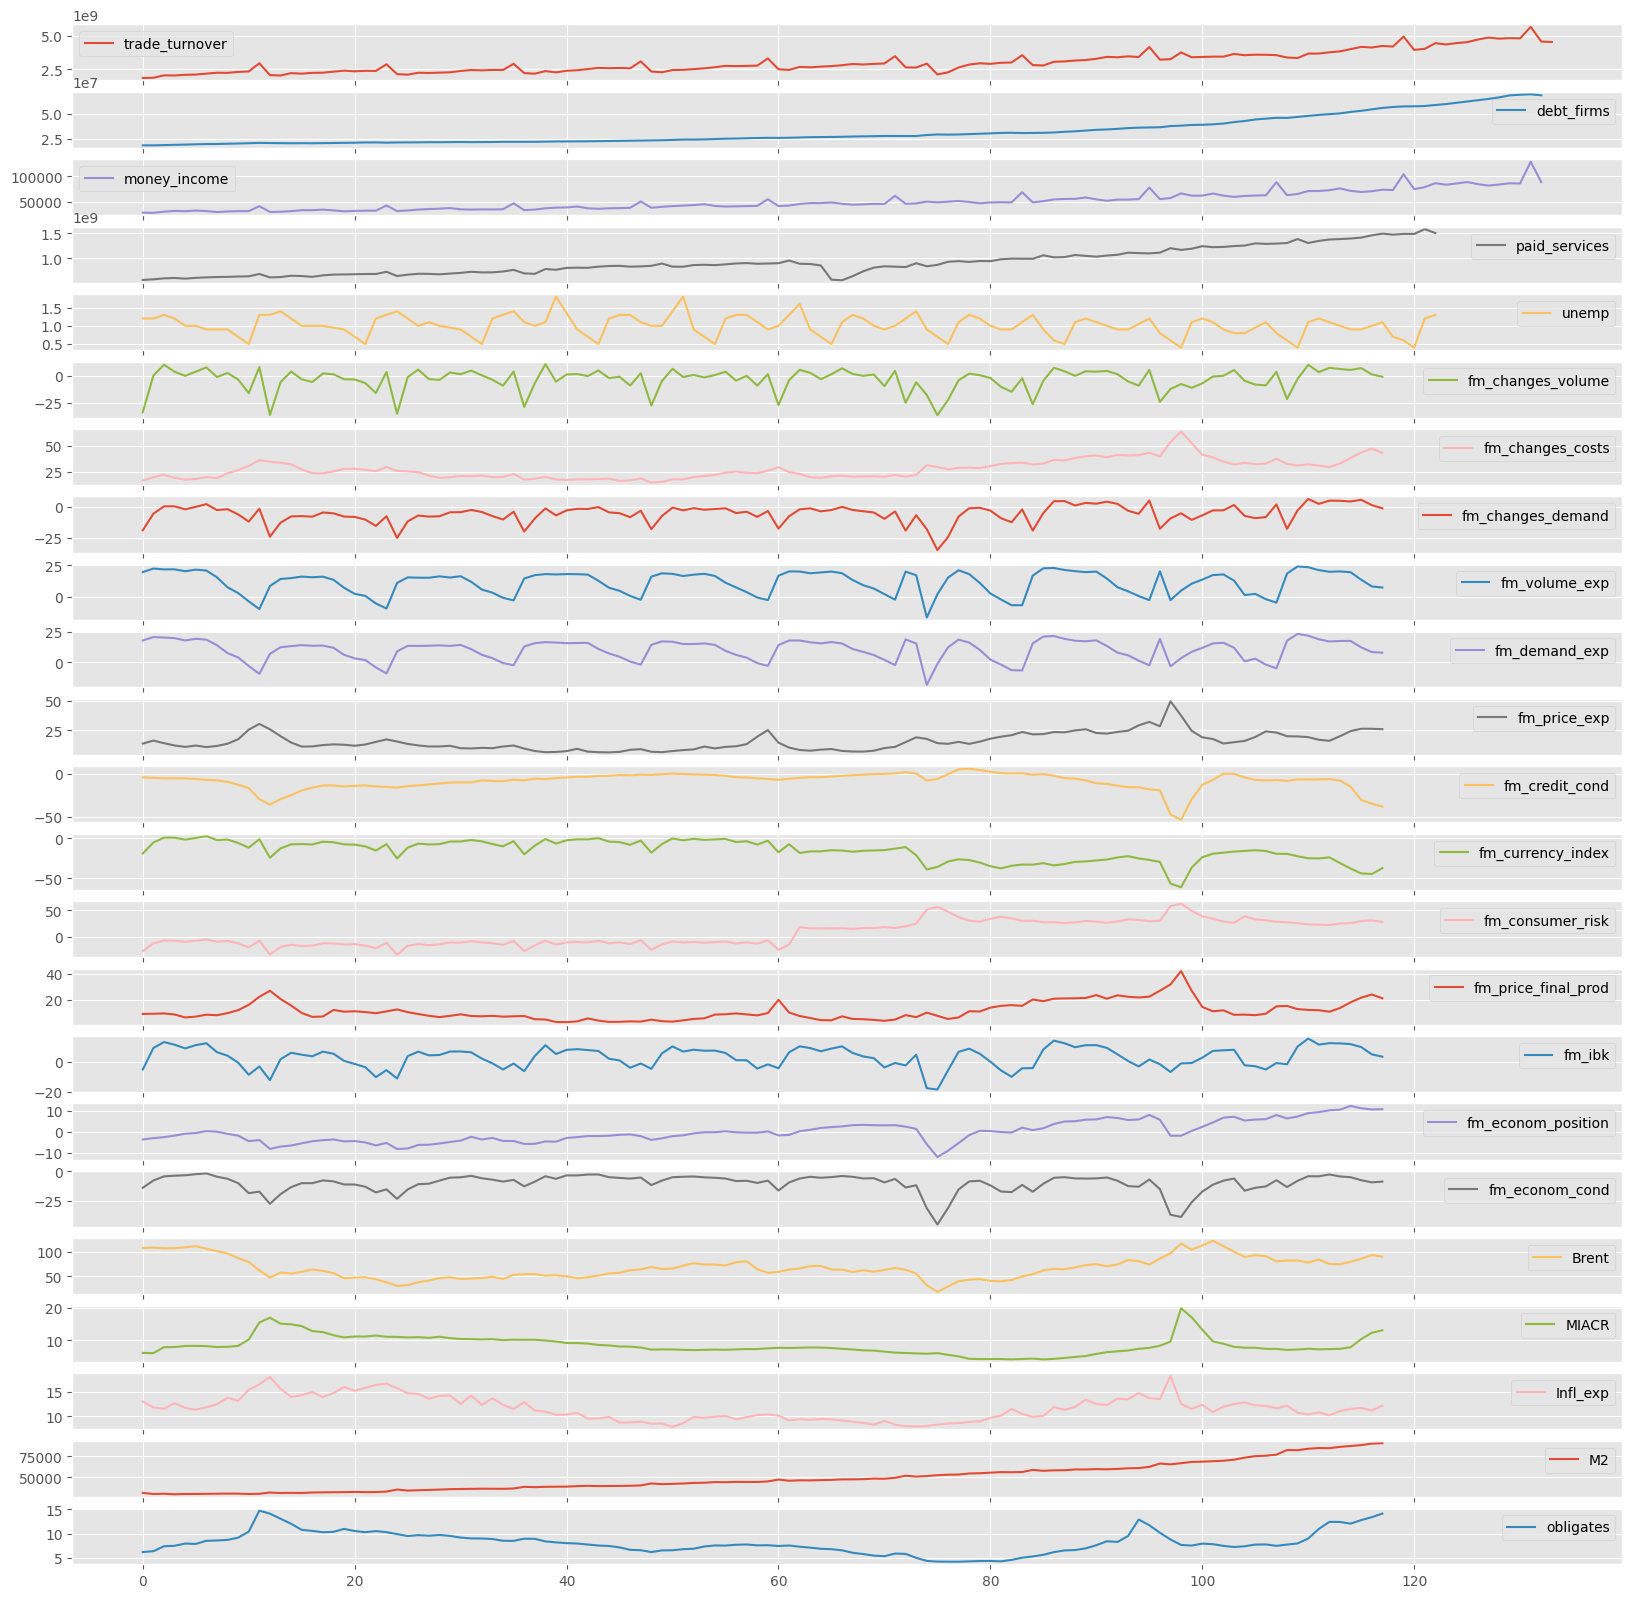

In [569]:
df.plot(kind='line', figsize=(20, 20), subplots=True);

## У денежных переменных вычищаем инфляцию

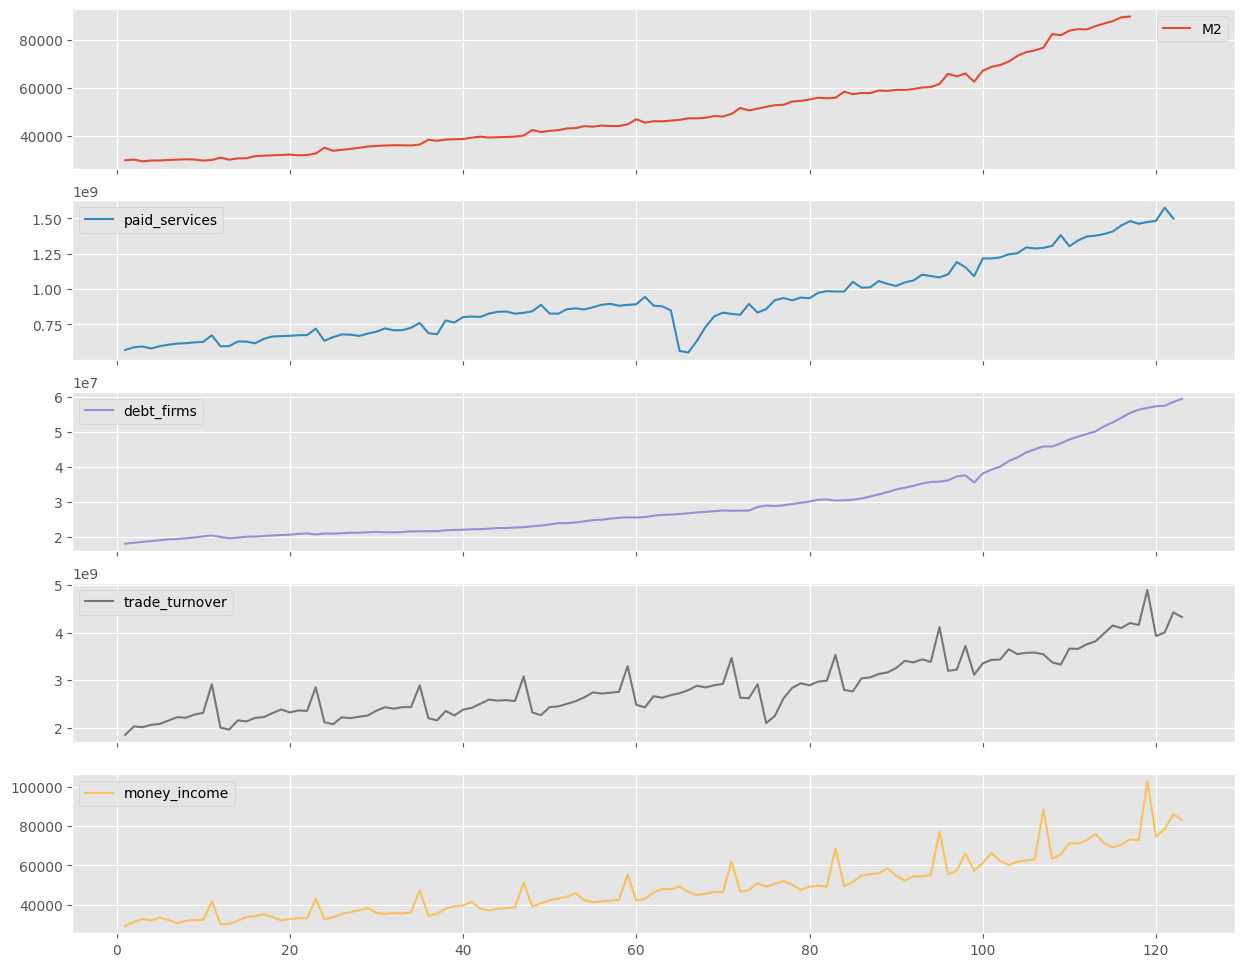

In [570]:
df_infl = df[['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
df_infl = df_infl.apply(lambda x: x / (y.shift(1)))
df = df.join(df_infl)
df_infl.plot(kind='line', figsize=(15, 12), subplots=True);

## Находим ряды с большой размерностью / экспоненциальным ростом и применяем логарифмирование


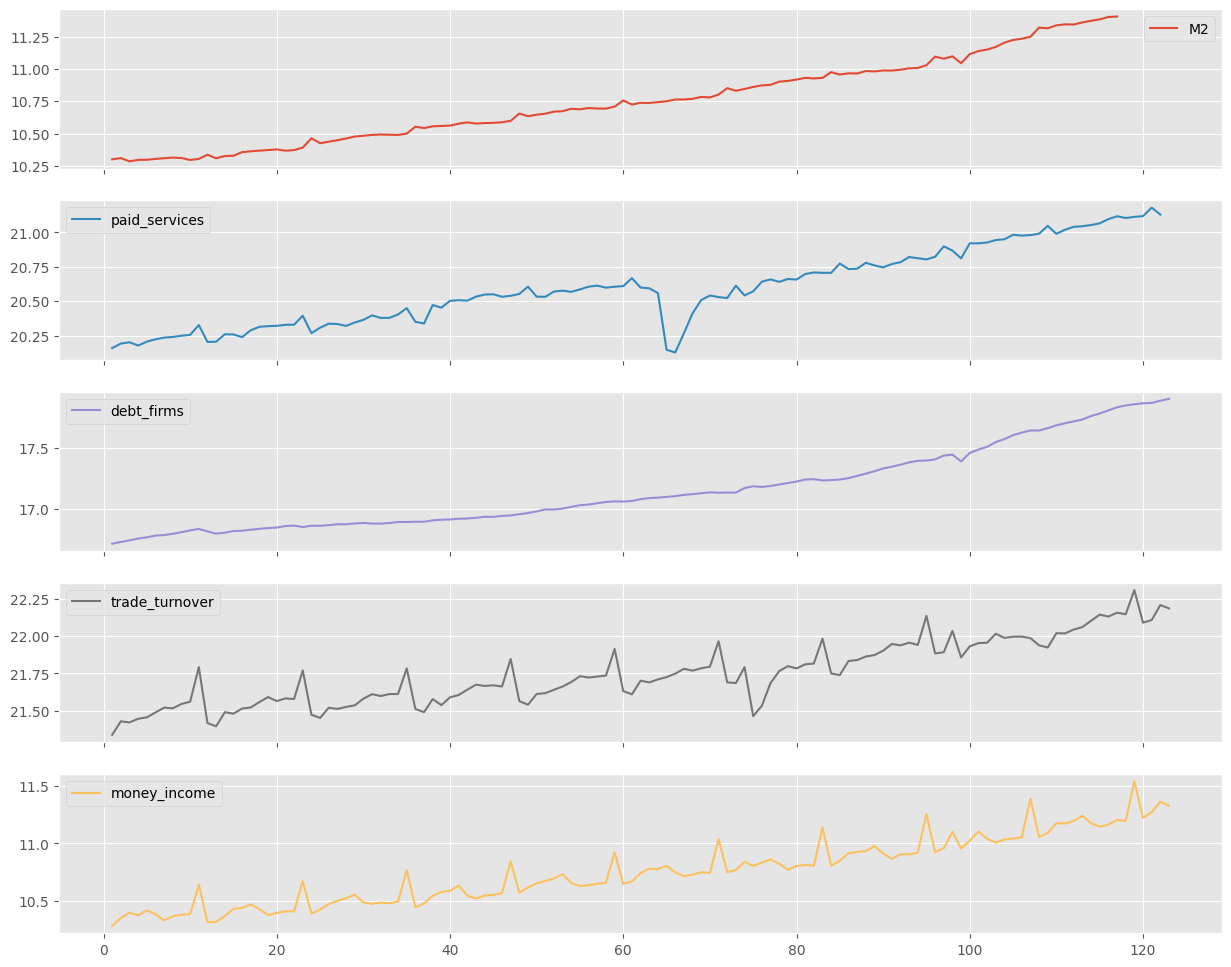

In [571]:
df_log = df[['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover', 'money_income'], axis=1, inplace=True)
df_log = df_log.apply(lambda x: np.log(x))
df = df.join(df_log)
df_log.plot(kind='line', figsize=(15, 12), subplots=True);

## Ищем ряды с ярко выраженной годовой сезонностью и применяем сезонную корректировку


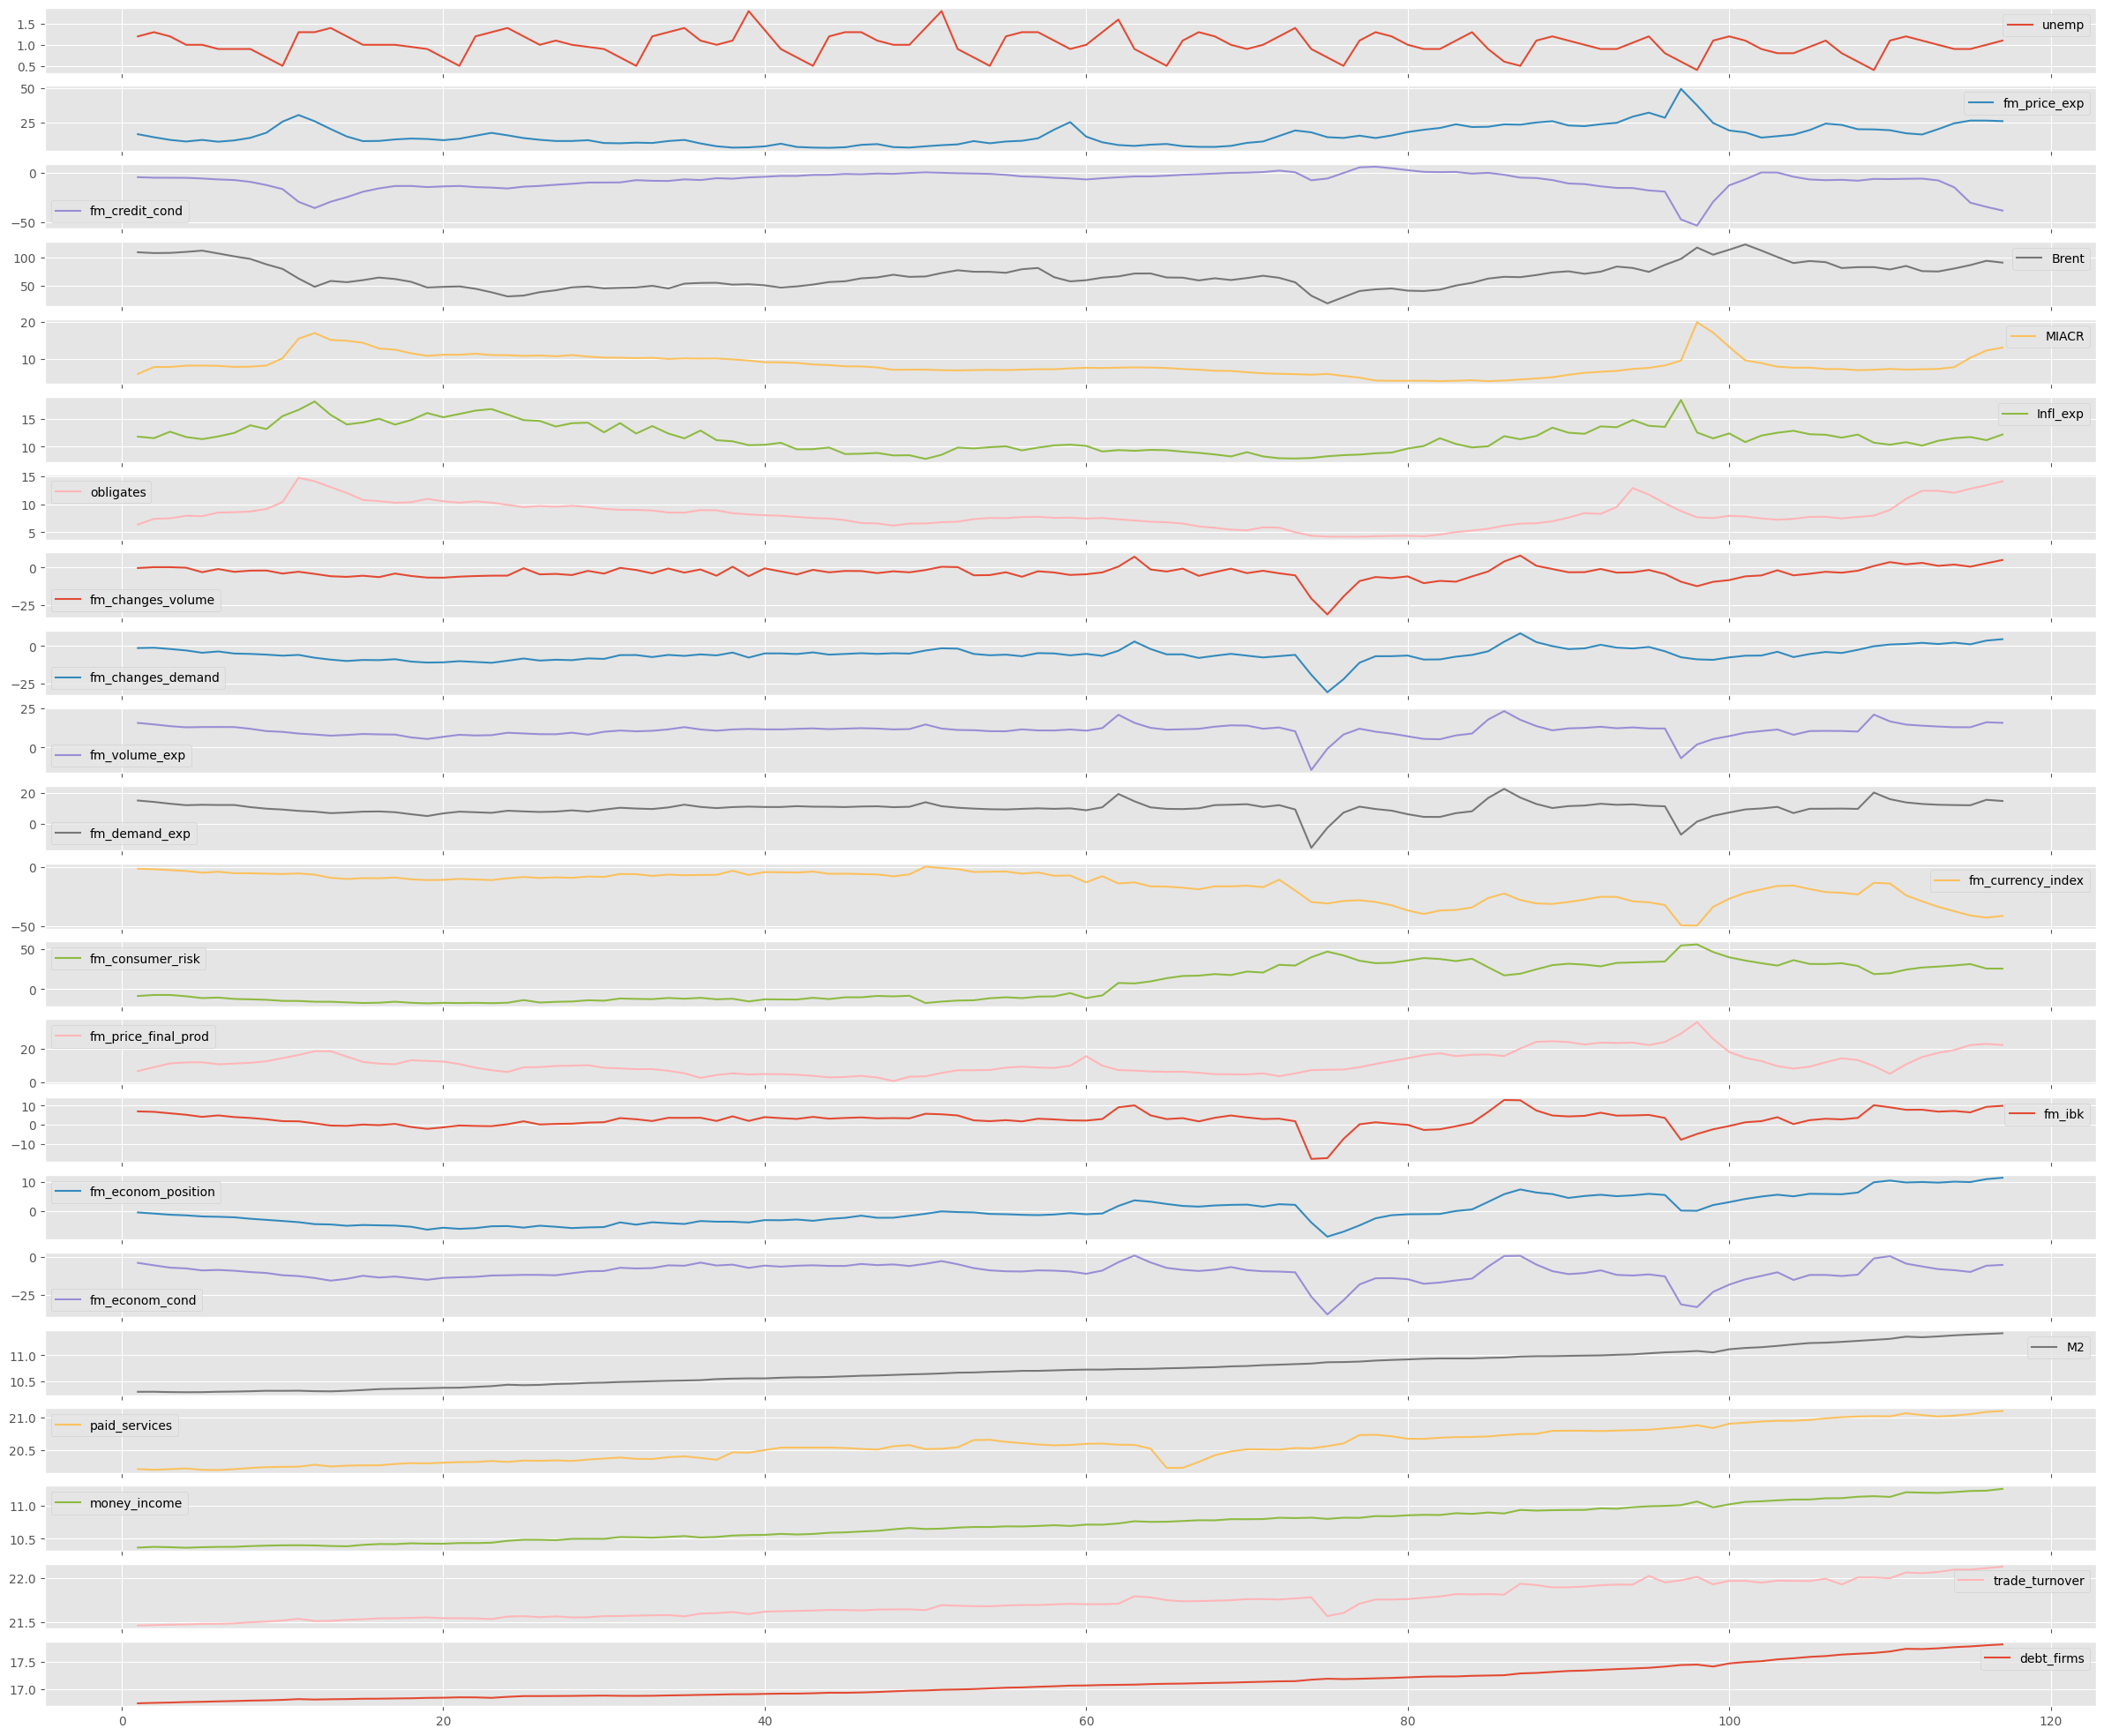

In [572]:
from statsmodels.tsa.seasonal import STL

df = df.dropna()

df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                  'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                  'fm_econom_position', 'fm_econom_cond','M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms']].copy()

df.drop(['fm_changes_volume', 'fm_changes_costs', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
         'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
         'fm_econom_position', 'fm_econom_cond','M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
df_seasonal = df_seasonal.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df = df.join(df_seasonal)
df.plot(kind='line', figsize=(30, 25), subplots=True);

Отдельно вычищаем безработицу, так как у неё сезонность по 11 месяцев

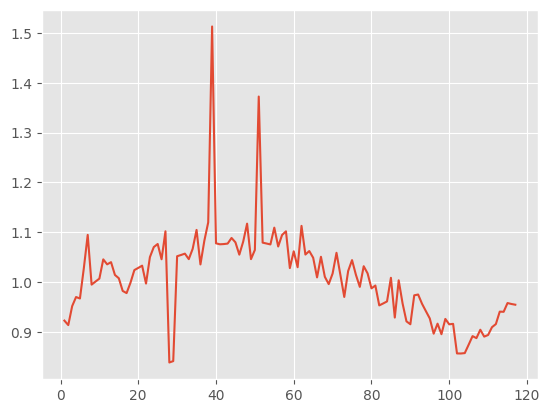

In [573]:
df['unemp'] = df['unemp'] - STL(df['unemp'], period=11).fit().seasonal
df['unemp'].plot();

## Берем первые разности и приводим ряды к 1 размерности

### Проверяем ряды на стационарность


In [574]:
# df = df.diff(1).dropna()
df = df.dropna()
df.apply(lambda x: adfuller(x)[1] < 0.05)

unemp                  False
fm_price_exp           False
fm_credit_cond         False
Brent                  False
MIACR                   True
Infl_exp               False
obligates              False
fm_changes_volume      False
fm_changes_demand      False
fm_volume_exp           True
fm_demand_exp           True
fm_currency_index      False
fm_consumer_risk       False
fm_price_final_prod    False
fm_ibk                  True
fm_econom_position     False
fm_econom_cond         False
M2                     False
paid_services          False
money_income           False
trade_turnover         False
debt_firms             False
dtype: bool

## Итоговое распределение рядов


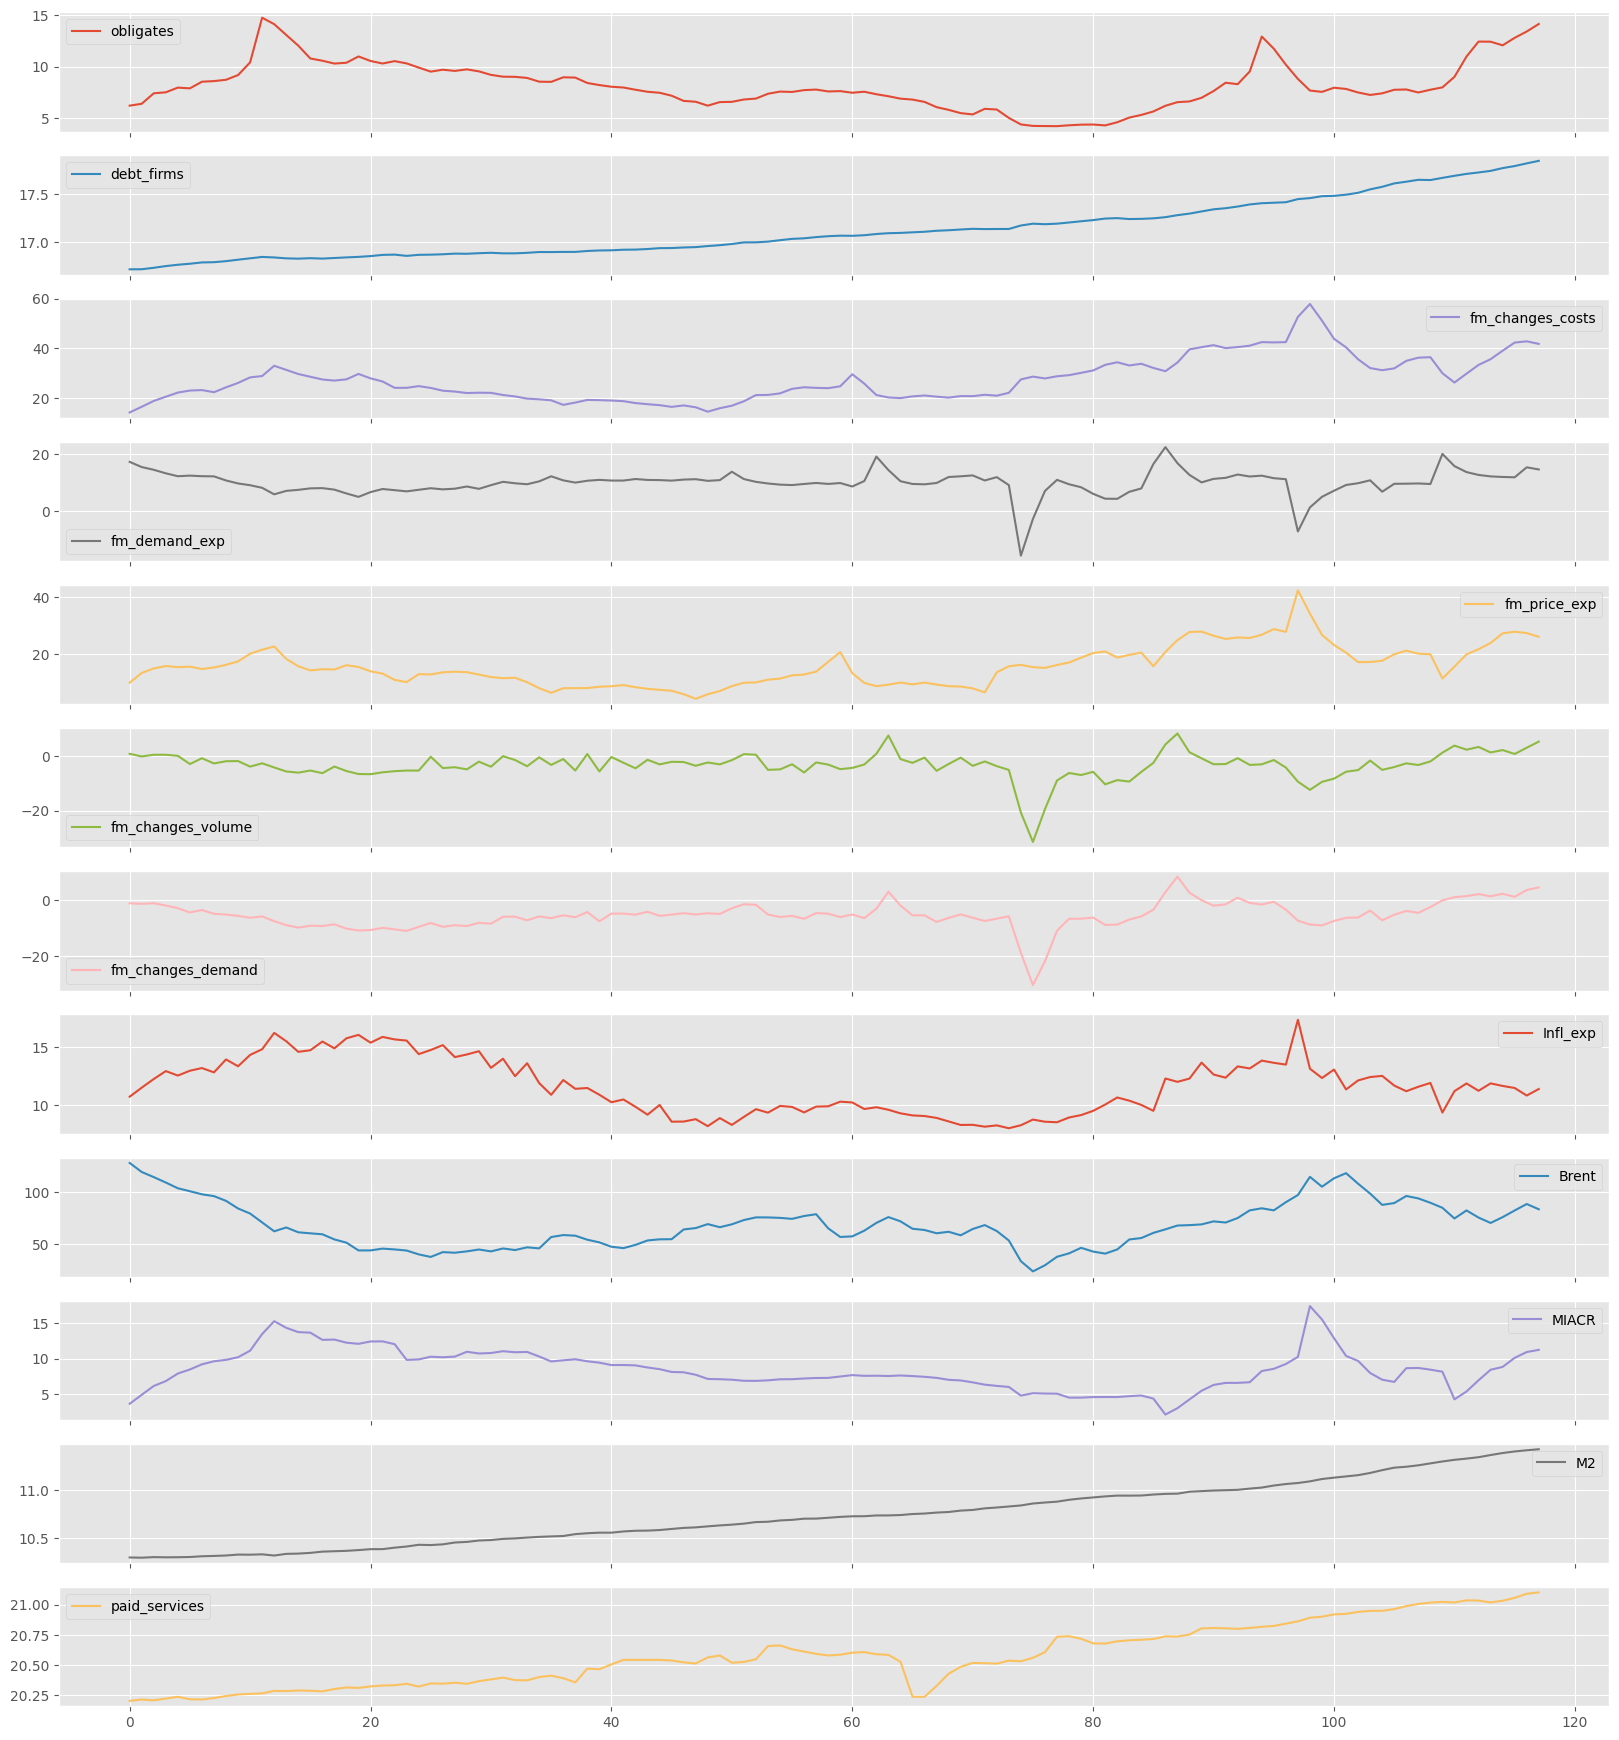

In [20]:
df.plot(kind='line', figsize=(20, 22), subplots=True)

## Применяем Метод главных компонент для переменных - опроссов коньюктуры рынка

### Формируем компоненты, объясняющие 90% дисперсии Х


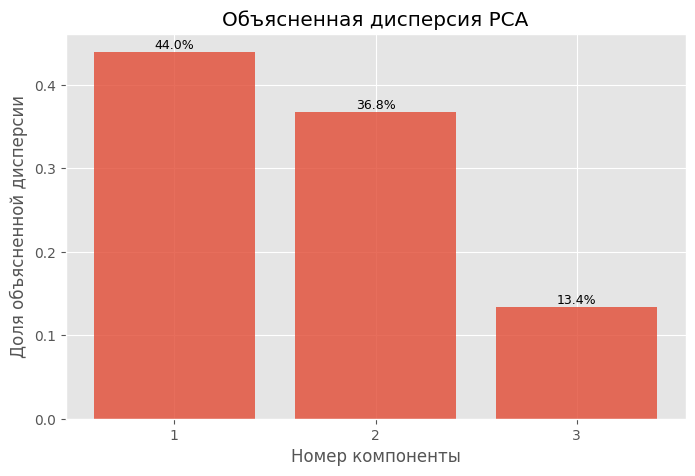

In [30]:
X_fm = df[['fm_changes_volume', 'fm_changes_demand', 'fm_demand_exp',
           'fm_changes_costs', 'fm_price_exp', 'Infl_exp']].copy()
X = df.drop(columns=['fm_changes_volume', 'fm_changes_demand',
            'fm_demand_exp', 'fm_changes_costs', 'fm_price_exp', 'Infl_exp'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fm)

pca = PCA(n_components=0.94)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
bars = plt.bar(range(1, len(explained_variance) + 1),
               explained_variance, alpha=0.8, align='center')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.xticks(np.arange(1, 4, 1))
plt.title('Объясненная дисперсия PCA')
plt.show()

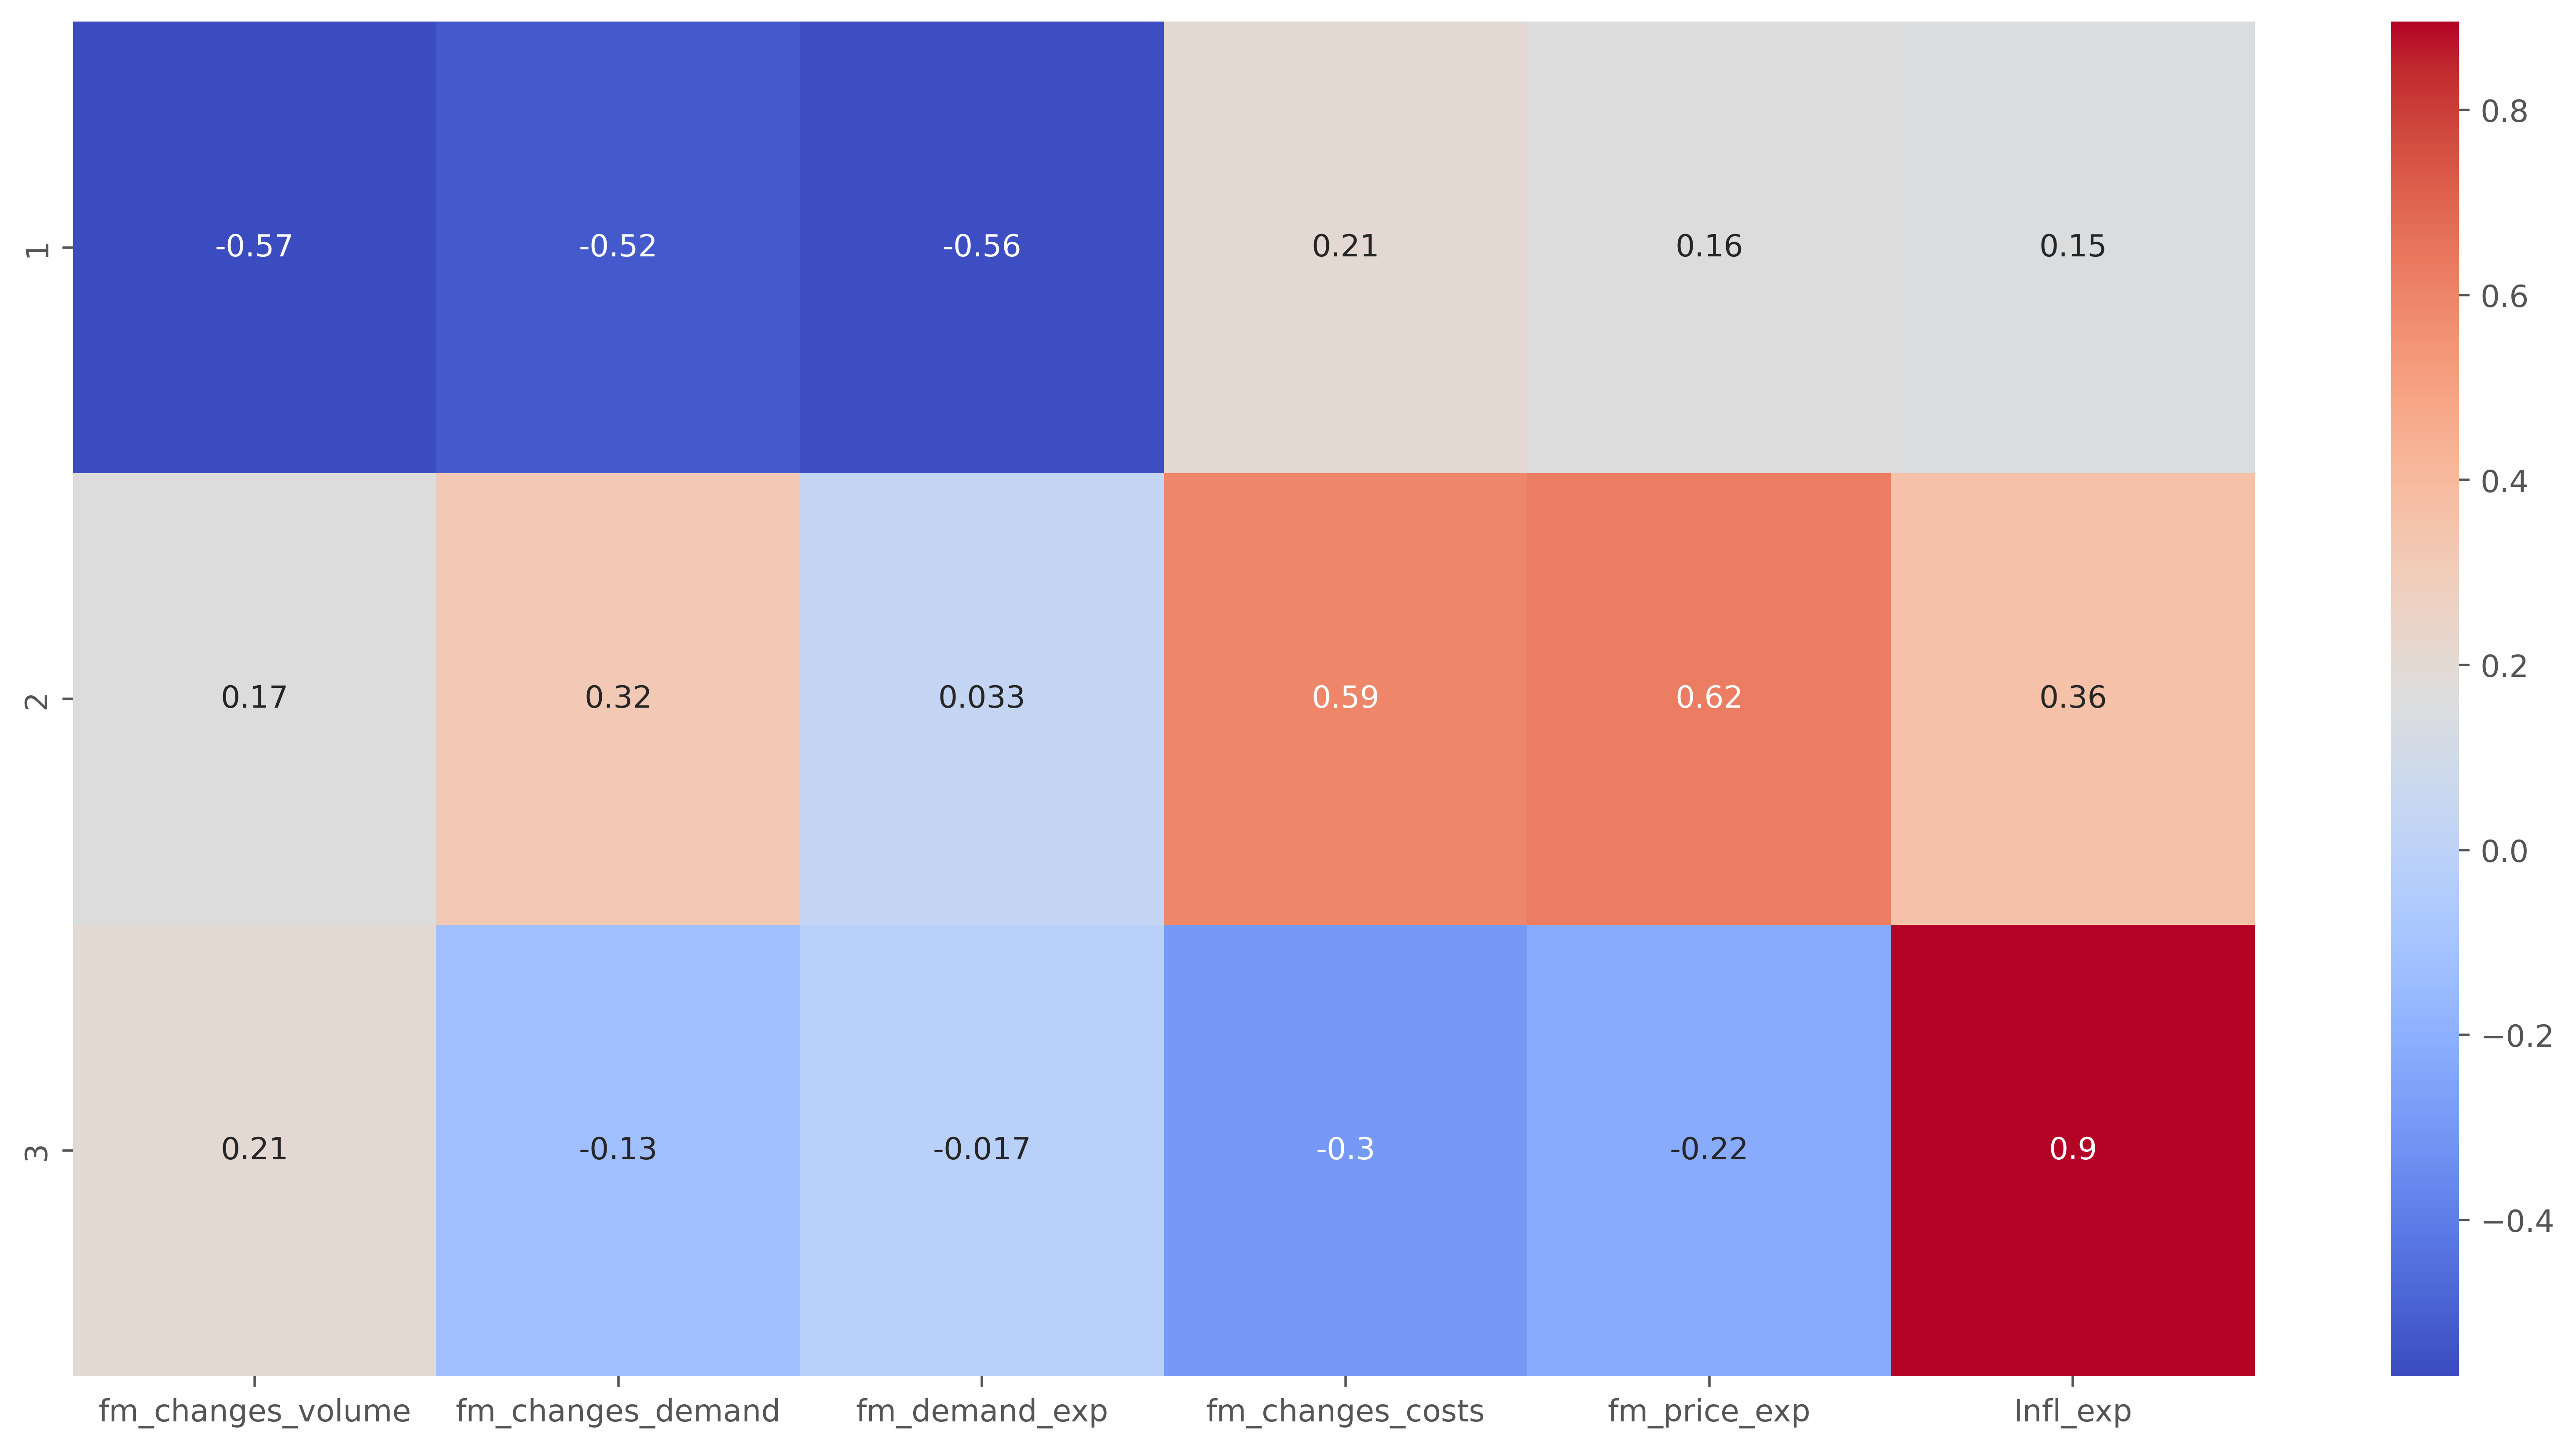

In [48]:
plt.figure(figsize=(16, 8), dpi=500)
loadings_data = pd.DataFrame(loadings, columns=X_fm.columns, index=range(1, 4))
sb.heatmap(loadings_data, annot=True, cmap='coolwarm')

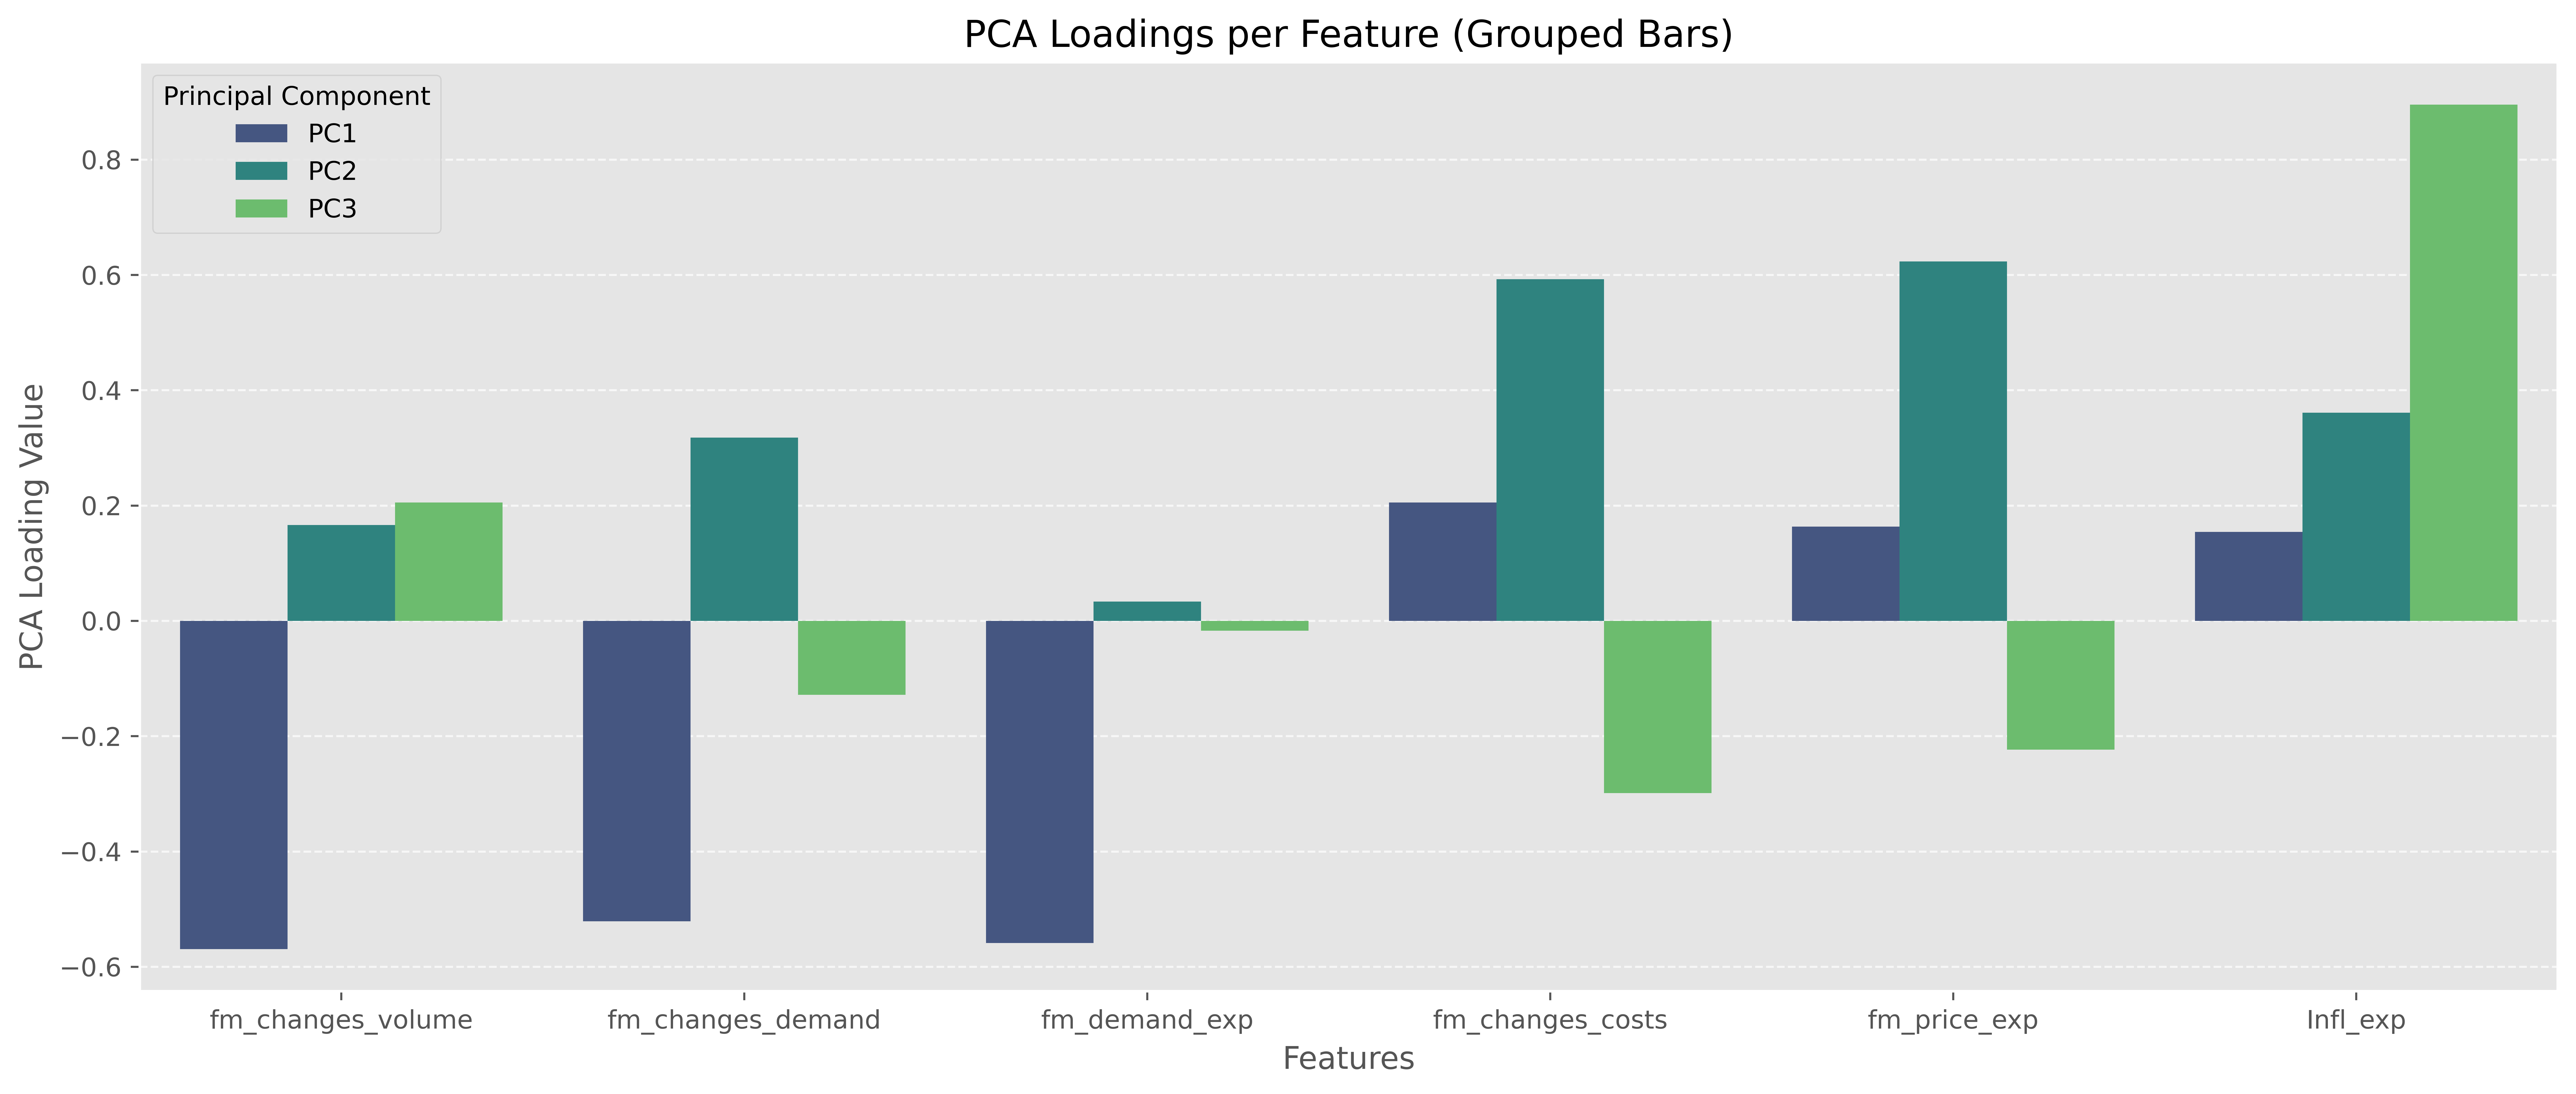

In [33]:
import seaborn as sns
import pandas as pd
feature_names = X_fm.columns
pc_names = [f'PC{i+1}' for i in range(pca.n_components_)]
# loadings_abs = np.abs(pca.components_)
loadings_abs = pca.components_


# Преобразуем loadings в DataFrame
loadings_df = pd.DataFrame(
    loadings_abs.T,  # Транспонируем, чтобы строки = признаки, столбцы = компоненты
    index=feature_names,
    columns=pc_names
).reset_index().melt(id_vars='index', var_name='PC', value_name='Loading')

# Переименуем колонки
loadings_df.columns = ['Feature', 'PC', 'Loading']

# Строим график
plt.figure(figsize=(14, 6), dpi=700)
sns.barplot(
    data=loadings_df,
    x='Feature',
    y='Loading',
    hue='PC',
    palette='viridis'
)

plt.title('PCA Loadings per Feature (Grouped Bars)')
plt.xlabel('Features')
plt.ylabel('PCA Loading Value')
plt.xticks(ha='center')
plt.legend(title='Principal Component', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
X_pca = pd.DataFrame(data=X_pca, columns=['PCA_1', 'PCA_2', 'PCA_3'])
X = X.join(X_pca).dropna()
X

,obligates,debt_firms,Brent,MIACR,M2,paid_services,PCA_1,PCA_2,PCA_3
0,6.20,16.72,127.87,3.67,10.30,20.20,-2.39,-1.09,0.34
1,6.39,16.72,119.13,4.92,10.30,20.21,-1.84,-0.57,0.42
2,7.40,16.73,114.18,6.16,10.30,20.20,-1.67,-0.12,0.60
3,7.50,16.75,108.95,6.84,10.30,20.22,-1.32,0.11,0.81
4,7.95,16.76,103.42,7.91,10.30,20.23,-1.03,0.04,0.63
...,...,...,...,...,...,...,...,...,...
113,12.42,17.74,69.93,8.43,11.37,21.02,-1.16,1.94,-0.43
114,12.06,17.77,75.55,8.83,11.39,21.03,-1.19,2.53,-0.73
115,12.79,17.79,81.98,10.10,11.41,21.06,-0.81,2.65,-0.95
116,13.40,17.81,88.22,10.92,11.42,21.09,-1.83,2.81,-1.19


In [50]:
import os
os.makedirs('processed_regional_data', exist_ok=True)
os.path.join(os.getcwd(), 'processed_regional_data')

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/processed_regional_data'

In [51]:
df = X.join(y)
df.to_csv('processed_regional_data/infl_rus.csv', index=False)

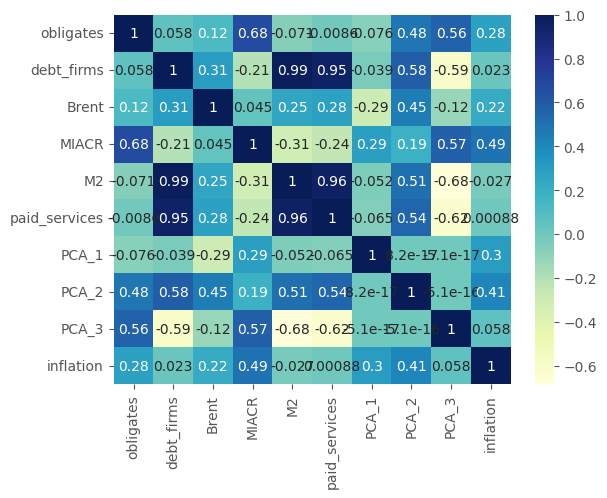

In [52]:
sb.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)